In [1]:
%reload_ext autoreload
%autoreload 2

from torch.utils.data import DataLoader
from datasets import DatasetEEG, DatasetEEGTorch
import torch
import numpy as np

from sklearn.svm import SVC
from utils import plot_training_metrics, count_model_parameters, train_model
from dataset_filters import normalize_signals, crop_signals


## Preparazione datasets
In questo esempio mostro come preparare i dati per analizzarli con modelli di reti neurali in pytorch. Inizio caricando i due dataset BCI, uno training e uno test, relativi al soggetto 1. I dati vengono poi normalizzati e croppati nell'intervallo tra 0.5 e 2.5 secondi. Ricordo che avere trial tutti della stessa lunghezza è essenziale per poter il corretto funzionamento di modelli basati su reti neurali.

In [2]:
# Carico i dataset per il training e il test
dataset_bci = DatasetEEG.load('DatasetBCI/Dataset_01_Training.dataset')
dataset_bci_test = DatasetEEG.load('DatasetBCI/Dataset_01_Test.dataset')

# Li normalizzo e croppo
normalize_signals(dataset_bci)
normalize_signals(dataset_bci_test)

crop_signals(dataset_bci, t_min=0.5, t_max=2.5)
crop_signals(dataset_bci_test, t_min=0.5, t_max=2.5)

# Mostro le caratteristiche dei due dataset
print(dataset_bci)
print(dataset_bci_test)

# Altre caratteristiche dei dati che serviranno successivamente
fs = 250
channels = 22
num_timepoints = dataset_bci.num_timepoints


num_trials               :  288
num_channels             :  22
num_timepoints           :  500
labels_type              :  int
subject                  :  1
fs                       :  250

num_trials               :  288
num_channels             :  22
num_timepoints           :  500
labels_type              :  int
subject                  :  1
fs                       :  250



Per poter minimizzare gli effetti dell'overfitting è utile separare il dataset di training in due parti, training e validation. Per far questo uso la funzione "split_dataset", con la divisione standard 80% training e 20% valdiation.

In [3]:
dataset_training, dataset_validation = dataset_bci.split_dataset(validation_size=0.2)

print(dataset_training)
print(dataset_validation)

num_trials               :  230
num_channels             :  22
num_timepoints           :  500
labels_type              :  int
subject                  :  1
fs                       :  250

num_trials               :  58
num_channels             :  22
num_timepoints           :  500
labels_type              :  int
subject                  :  1
fs                       :  250



Per poter funzionare con i modelli pytorch i dataset devono essere trasformati in DatasetEEGTorch

In [4]:
dataset_training_pytorch = DatasetEEGTorch(dataset_training)
dataset_validation_pytorch = DatasetEEGTorch(dataset_validation)
dataset_test_pytorch = DatasetEEGTorch(dataset_bci_test)

Di default pytorch assume che si lavori su CPU, ma se si ha a disposizione una GPU con CUDA è possibile sfruttarla. Per il corretto funzionamento bisogna spostare i dati (oltre che i modelli) sulla GPU. Ciò si può fare in due modi:
- Spostare i singoli batch di dati al momento in cui vengono generati e poco prima di essere processati
- Spostare l'intero dataset sulla GPU dal principio, eliminando i tempi necessari a spostare i dati durante il training

Il secondo metodo è possibile solo se la memoria della GPU è abbastanza grande da contenere l'intero tensore che rappresenta il dataset. La funzione "to_device" sposta l'intero dataset sul device scelto (eventualmente potrebbe funzionare anche con TPU)

In [5]:
# Se è presente la GPU sfrutto quella e sposto i dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

dataset_training_pytorch.to_device(device)
dataset_validation_pytorch.to_device(device)
dataset_test_pytorch.to_device(device)


cuda


/home/nuzzi/Projects/EEG_Pipeline/EEG-ANN-Pipeline/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


L'ultimo step prima di passare ai modelli è creare dei DataLoader. Queste classi (native di pytorch) gestiscono automaticamente la generazione di batch di dati a partire dai dataset, specificando anche se è possibile generare batch parziali (se la lunghezza dei samples non è un multiplo della batch size), se randomizzare i samples a ogni epoca, ecc.

In [6]:
# Creo i dataloader
batch_size = 32
dataloader_training = DataLoader(dataset_training_pytorch, batch_size=batch_size, shuffle=True)
dataloader_validation = DataLoader(dataset_validation_pytorch, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(dataset_test_pytorch, batch_size=batch_size, shuffle=False)

### Support Vector Machine Classifier
Come modello semplice di benchmark addestro una SVC direttamente sui segnali EEG. Lo addestro usando le informazioni su tutti i tempi e tutti i canali come features, cosa dispendiosa ma accettabile per un dataset così piccolo.

Nota: poiché sto usando i Dataset di pytorch e ho già spostato i dati sulla GPU, devo prima riportarli sulla CPU e staccarli dall'albero di pytorch (usando le funzioni cpu() e detach())

In [7]:
# Inizializzo il modello
model_svc = SVC()

# Estraggo segnali e labels dal dataset di training
labels = dataset_training_pytorch.labels.detach().cpu().numpy()
features = dataset_training_pytorch.eeg_signals.squeeze().detach().cpu().numpy()
features = np.reshape(features, (dataset_training_pytorch.num_trials, -1))

# Fit del modello e calcolo accuratezza
model_svc.fit(features, labels)
accuracy = model_svc.score(features, labels)

print(f'Training accuracy = {accuracy*100:.2f}%')

# Ripeto sul testing set (senza fare ovviamente il fit)
labels = dataset_test_pytorch.labels.detach().cpu().numpy()
features = dataset_test_pytorch.eeg_signals.squeeze().detach().cpu().numpy()
features = np.reshape(features, (dataset_test_pytorch.num_trials, -1))

accuracy = model_svc.score(features, labels)

print(f'Test accuracy = {accuracy*100:.2f}%')

Training accuracy = 97.83%
Test accuracy = 33.33%


### ShallowNet
Utilizzo l'architettura ShallowNet (due convoluzioni separate su tempi e su canali e specifiche funzioni di attivazione). 

Dopo aver creato la rete la sposto su GPU e conto il numero di parametri del modello.

Successivamente definisco l'ottimizzatore da usare per la backpropagation e passo tutto a una funzione di utility "train_model" che si occupa di eseguire tutti i passaggi necessari al training e di collezionare le metriche (loss, accuracy, ecc) di interesse. Se viene passato anche un dataloader per il validation set la funzione esegue anche una fase di test su quest'ultimo durante ogni epoca e colleziona le metriche di validation. Le metriche mostrate nella progressbar sono quelle di training se non viene fornito il validation dataloader, altrimenti sono quelle di validation.

Infine uso un'altra funzione di utility "plot_training_metrics" per visualizzare le metriche, separandole automaticamente tra training e validation.

In [8]:
from models.EEGNetModels import ShallowNet

filters = 40 # Numero di filtri per le due convoluzioni

model = ShallowNet(num_classes=4, channels=channels, filters=filters)
model.to(device)
print(f'Il modello ha {count_model_parameters(model)} parametri')


Il modello ha 35840 parametri


100%|██████████| 100/100 [00:05<00:00, 17.33it/s, loss=1.52, accuracy=0.586]


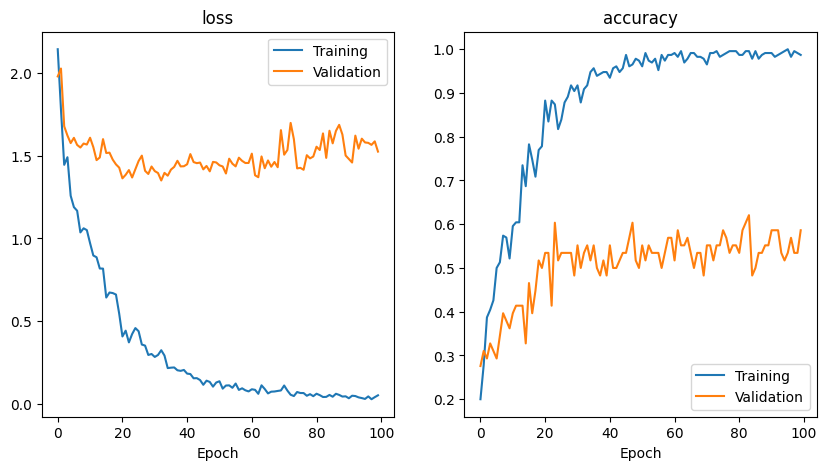

In [9]:
# Ottimizzatore
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Faccio il training e ottengo la storia di tutte le metriche
metrics = train_model(model, optimizer, dataloader_training,
                      dataloader_validation=dataloader_validation)

# Plot risultati del training
plot_training_metrics(metrics)

Calcolo l'accurattezza sul test set. Per farlo uso la funzione "predict" del modello che restituisce direttamente la label di probabilità massima per un batch di dati

In [10]:
# Setto il modello in modalità eval (non training)
model.eval()

# Inizializzo per accumulare poi in ogni batch
accuracy = 0

# Ciclo sul test set
for i, batch in enumerate(dataloader_test):

    x, y = batch
    y_pred = model.predict(x)

    # Calcolo l'accuratezza
    accuracy += torch.sum(y_pred == y).item()

accuracy /= len(dataloader_test.dataset)

print(f'Accuratezza sul test set = {accuracy:.4f}')


Accuratezza sul test set = 0.5000


## DeepNet
Ripeto le stesse analisi con il modello DeepNet

In [11]:
from models.EEGNetModels import DeepNet

model = DeepNet(num_classes=4, channels=channels)
model.to(device)
print(f'Il modello ha {count_model_parameters(model)} parametri')


Il modello ha 277525 parametri


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:17<00:00, 11.63it/s, loss=1.25, accuracy=0.655] 


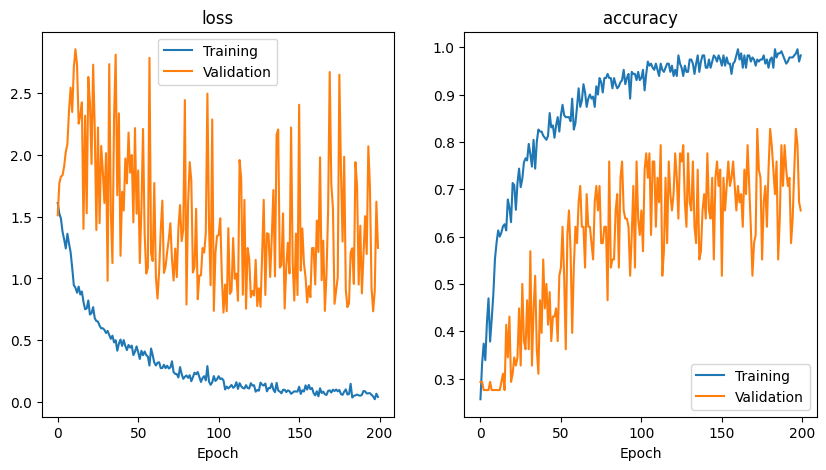

In [12]:
# Ottimizzatore
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Faccio il training e ottengo la storia di tutte le metriche
metrics = train_model(model, optimizer, dataloader_training, dataloader_validation, epochs=200)

# Plot risultati del training
plot_training_metrics(metrics)

In [13]:
# Setto il modello in modalità eval (non training)
model.eval()

# Inizializzo per accumulare poi in ogni batch
accuracy = 0

# Ciclo sul test set
for i, batch in enumerate(dataloader_test):

    x, y = batch
    y_pred = model.predict(x)

    # Calcolo l'accuratezza
    accuracy += torch.sum(y_pred == y).item()

accuracy /= len(dataloader_test.dataset)

print(f'Accuratezza sul test set = {accuracy:.4f}')


Accuratezza sul test set = 0.6736


### EEGNet
Infine, ripeto con il modello più potente, anche se con molti meno parametri degli altri

In [14]:
from models.EEGNetModels import EEGNet

model = EEGNet(num_classes=4, channels=channels)
model.to(device)
print(f'Il modello ha {count_model_parameters(model)} parametri')


Il modello ha 1456 parametri


  0%|          | 0/200 [00:00<?, ?it/s]

/home/nuzzi/Projects/EEG_Pipeline/EEG-ANN-Pipeline/.venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:454: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 200/200 [00:10<00:00, 18.64it/s, loss=0.581, accuracy=0.828]


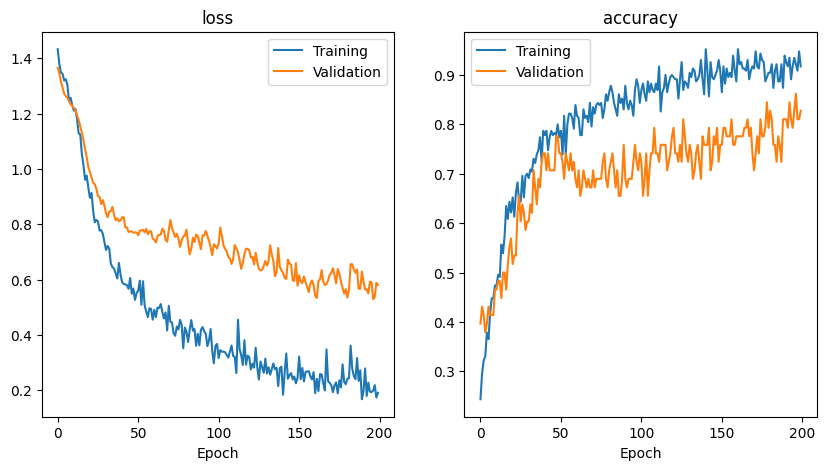

In [15]:
# Ottimizzatore
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Faccio il training e ottengo la storia di tutte le metriche
metrics = train_model(model, optimizer, dataloader_training, dataloader_validation, epochs=200)

# Plot risultati del training
plot_training_metrics(metrics)

In [16]:
# Setto il modello in modalità eval (non training)
model.eval()

# Inizializzo per accumulare poi in ogni batch
accuracy = 0

# Ciclo sul test set
for i, batch in enumerate(dataloader_test):

    x, y = batch
    y_pred = model.predict(x)

    # Calcolo l'accuratezza
    accuracy += torch.sum(y_pred == y).item()

accuracy /= len(dataloader_test.dataset)

print(f'Accuratezza sul test set = {accuracy:.4f}')


Accuratezza sul test set = 0.7257
